In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import gsw
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

# To-do
- estimate wavenumber with max growth rate for each simulation
    - requires knowing rotation rate...
- look at temperature data...

# Dimensions

Parameters/dimensions of bucket (inches):
\begin{align*}
    r_{can} &= 3.5\\
    r_{inner}  &= 9\\
    %r_{outer} &= 12\\
    H &= 5
\end{align*}
Convert to cm:

In [2]:
cm_per_in  = 2.54
r_can_in   = 3.5
r_inner_in = 9
H_in       = 5.25
r_can, r_inner, H = [i*cm_per_in/100 for i in [r_can_in, r_inner_in, H_in]]
print('measurements in m:')
print(f'r_can   = {r_can:.3f}')
print(f'r_inner = {r_inner:.3f}')
print(f'H       = {H:.3f}')

radii = np.array([r_can, (r_can*3+r_inner)/4, (r_can+r_inner)/2, r_inner])

measurements in m:
r_can   = 0.089
r_inner = 0.229
H       = 0.133


#### Sensor locations

In [3]:
sensor_hgt_in = np.array([[1.0 , 4.25], # inches
                          [2.0 , 5.0],
                          [1.5 , 4.5],
                          [0.75, 3.5]])
sensor_hgt_in = sensor_hgt_in[:,::-1] # reverse order so that height of upper sensor is in left column
sensor_depth  = (H_in-sensor_hgt_in) * cm_per_in / 100 # m
print(sensor_depth)

[[0.0254  0.10795]
 [0.00635 0.08255]
 [0.01905 0.09525]
 [0.04445 0.1143 ]]


### Estimate $f_0$ from movies.

Observed minutes per revolution

In [4]:
## 100 experiment
t1_min = 6+(47/60)
t2_min = 8+(54/60)
T100 = t2_min-t1_min

## 300 experiment
t3_min = 17/60
t4_min = 58/60
T300 = t4_min-t3_min

## 500 experiment
T500 = (50-25)/60

### convert to radians/sec

In [5]:
def convert_to_rad_per_sec(T):
    '''convert period from minutes per revolution to radians/sec'''
    sec_per_rev = T*60
    rad_per_sec = 2*np.pi / sec_per_rev
    return rad_per_sec
print('stated rate    rad/s')
for i in [1,3,5,10,20,30]:
    print(f'{int(1e2*i)}            {convert_to_rad_per_sec(T100/i):.2f}')

stated rate    rad/s
100            0.05
300            0.15
500            0.25
1000            0.49
2000            0.99
3000            1.48


# Wavenumber of max growth

Buoyancy frequency computed as:
\begin{align*}
    N^2 &= g^2\rho\frac{\alpha \Delta T}{\Delta P}
\end{align*}

Wavenumber which maximizes growth rate:
\begin{align*}
    \kappa = 2\frac{f_0}{N_0H}
\end{align*}

In [6]:
f0       = .15
t        = np.array([17.5, 14])[:,None] # temperature (deg C)
SA       = np.zeros_like(t)             # Salinity (zero)
p        = np.array([.03, H])[:,None] # pressure (based on depth of tank)
CT       = gsw.CT_from_t(SA, t, p)      # conservative temperature
N2,p_mid = gsw.Nsquared(SA,CT,p)
N0       = np.sqrt(N2)

## Compute kappa
r_mid          = radii[2] # mid-point between can wall and edge of inner bucket
circ           = 2 * np.pi * r_mid # max wavelength in theta-direction (circumference of can; units of m)
kappa_rad_m    = 2*f0/(N0*H)       # units of radians/m
kappa_cyc_m    = kappa_rad_m / (2*np.pi) # units of cycles/m
kappa          = kappa_cyc_m * circ # wavenumber of maximum growth ("planetary wavenumber")

print(f'kappa_max = {kappa.item():.1f}')

kappa_max = 1.6


# Load real temperature data

In [7]:
T_data = pd.ExcelFile('data.xlsx')
T_data = pd.read_excel(T_data, sheet_name=None)
old_keys = list(T_data)
R_vals   = [2000,500,300,100]
T_data   = {k_new : T_data[k_old] for k_new, k_old in zip(R_vals, old_keys)}
time_s   = T_data[100].iloc[:,0].values
time_min = time_s/60

In [33]:
def get_N0(T,p):
    '''Compute buoyancy frequency given Temperature and pressure.
    Each column corresponds to different sensor'''
    SA  = np.zeros_like(T)              # salinity = 0
    p   = np.tile(p, (T.shape[0],1))      # reshape to match temperature
    CT  = gsw.CT_from_t(SA,  T, p) # conservative temperature
    N2,_= gsw.Nsquared( SA, CT, p, axis=1)   # buoyancy frequency squared
    return np.sqrt(N2)

def get_f0(R):
    '''Compute f0 based on "R" value'''
    Omega = R/2000
    return 2*Omega

def get_Ld(T,p,R,H):
    '''Compute deformation radius'''
    N  = get_N0(T,p)
    f0 = get_f0(R)
    return N*H/f0

def get_kappa(Ld, radius):
    '''Compute max wavenumber based on deformation radius (Ld) and distance from center (radius).
    Distance from center matters because this value is the number of waves which "fit" in the domain'''
    circ        = 1.6 * np.pi * radius # circumference of can; units of m
    kappa_rad_m = 2/Ld       # units of radians/m
    kappa_cyc_m = kappa_rad_m / (2*np.pi) # units of cycles/m
    kappa       = kappa_cyc_m * circ # wavenumber of maximum growth ("planetary wavenumber")
    return kappa

def compute_kappa(r):
    ## Compute number of waves which fit in domain
    X     = T_data[r]
    kappas= []
    Lds   = [] # deformation radii
    for j in range(4):
        i  = 2*(j+1) # index for upper sensor column
        
        # Compute buoyancy frequency
        T     = X.iloc[:,i:i+2].values         # temp. at upper/lower sensor
        p     = sensor_depth[j:j+1]           # get pressure at sensor locations
        Ld    = get_Ld(T,p,r,H)
        kappa = get_kappa(Ld, radii[j])
        kappas.append(kappa)
        Lds.append(Ld)
    return np.concatenate(kappas, axis=1), np.concatenate(Lds, axis=1)

# def compute_kappa(r):
#     ## Compute number of waves which fit in domain
#     X     = T_data[r]
#     kappas= []
#     Lds   = [] # deformation radii
#     for j in range(4):
#         i  = 2*(j+1) # index for upper sensor column
        
#         # Compute buoyancy frequency
#         T  = X.iloc[:,i:i+2].values         # temp. at upper/lower sensor
#         SA = np.zeros_like(T)              # salinity = 0
#         p  = sensor_depth[j:j+1]           # get pressure at sensor locations
#         p  = np.tile(p, (X.shape[0],1))      # reshape to match temperature
#         CT       = gsw.CT_from_t(SA,  T, p) # conservative temperature
#         N2,p_mid = gsw.Nsquared( SA, CT, p, axis=1)   # buoyancy frequency squared
#         N0       = np.sqrt(N2)
        
#         ## Compute kappa
#         radius = radii[j] # radius of sensor
#         circ   = 2 * np.pi * radius # max wavelength in theta-direction (circumference of can; units of m)
#         Omega  = r/2000 # rotation rate in rad/s
#         f0     = 2*Omega
#         Ld     = N0*H/f0
#         kappa_rad_m    = 2/Ld       # units of radians/m
#         kappa_cyc_m    = kappa_rad_m / (2*np.pi) # units of cycles/m
#         kappa          = kappa_cyc_m * circ # wavenumber of maximum growth ("planetary wavenumber")
#         kappas.append(kappa)
#         Lds.append(Ld)
#     return np.concatenate(kappas, axis=1), np.concatenate(Lds, axis=1)

# kappas = np.stack([compute_kappa(r) for r in R_vals], axis=2)
results = np.stack([np.stack(compute_kappa(r),axis=2) for r in R_vals], axis=2)
kappas, Lds = results[...,0], results[...,1]

# results2 = np.stack([np.stack(compute_kappa2(r),axis=2) for r in R_vals], axis=2)
# kappas2, Lds2 = results2[...,0], results2[...,1]

/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


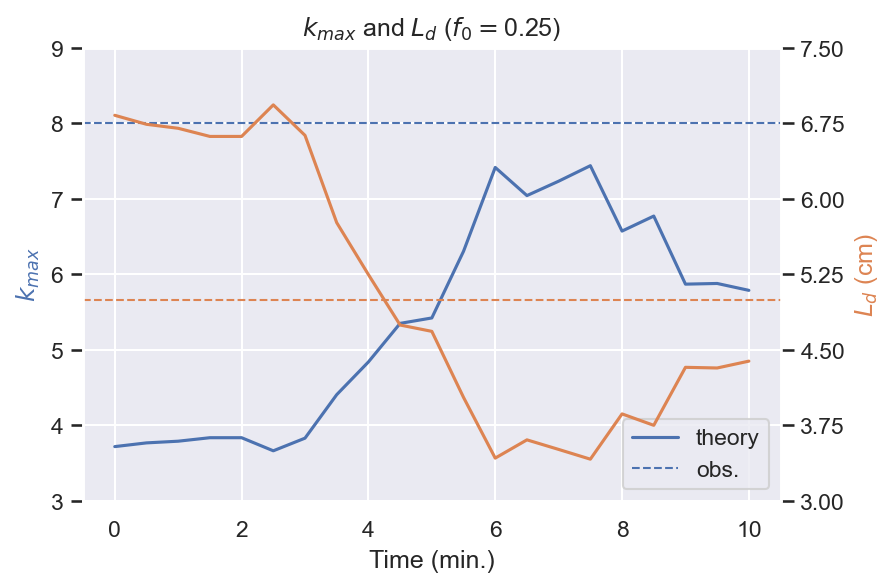

In [35]:
ri    = 1    # index of rotation rate
si    = -2    # index of sensor
k_est = 8
Ld_est= 5
alpha=.05 # plotting hyper-params 
lw   = 1

colors = sns.color_palette()
fig,ax = plt.subplots()
ax.set_title(r'$k_{max}$ and $L_d$ ($f_0=$'+f'{R_vals[ri]/2000:.2f})')

### plot k
ax.plot(time_min, kappas[:,si,ri], c=colors[0], label='theory')
ax.axhline(k_est, c=colors[0],ls='--', label='obs.', lw=lw)
ax.set_ylabel(r'$k_{max}$', c=colors[0])
ax.set_xlabel('Time (min.)')
# ax.set_ylim([0,30])

### plot Ld
ax2 = ax.twinx()
ax2.grid(False)
ax2.plot(time_min, 100*Lds[:,si,ri], label='L_d', c=colors[1])
ax2.axhline(Ld_est, c=colors[1],ls='--', lw=lw)
ax2.set_ylabel(r'$L_d$ (cm)', c=colors[1])
# ax2.set_ylim([0,6])

ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], len(ax.get_yticks())))
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

ax.legend(loc='lower right')
plt.show()

### Old code

In [ ]:
# c0, c1 = 5.75, 6.25
# ax.axhline(c0, c=colors[0],ls='--', label='obs.', lw=lw)
# ax.axhline(c1, c=colors[0],ls='--', lw=lw)
# ax.fill_between(x=[time_min[0],time_min[-1]], y1=[c0,c0], y2=[c1,c1], alpha=alpha)